PROYECTO

Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [4]:
agri_df = pd.read_csv("/workspaces/proyectfinaltour/data/processed/unificado/agri.csv", encoding='latin1')
weather_df = pd.read_csv("/workspaces/proyectfinaltour/data/processed/unificado/weather.csv")

In [5]:
weather_df.head()

,city,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,Barcelona,2008-07-01,27,22,0.0,14.5,6,6,4,04:04 AM,...,25,19,8,63,0.0,1015,27,10,248,12
1,Barcelona,2008-07-02,25,19,0.0,14.5,6,6,0,05:07 AM,...,24,11,6,78,0.0,1012,25,10,218,9
2,Barcelona,2008-07-03,25,20,0.0,14.5,6,6,0,06:21 AM,...,23,14,22,73,0.0,1012,25,10,164,11
3,Barcelona,2008-07-04,25,19,0.0,14.5,6,6,3,07:41 AM,...,22,22,5,68,0.0,1017,25,10,186,16
4,Barcelona,2008-07-05,27,20,0.0,14.5,6,6,10,08:59 AM,...,24,18,5,74,0.0,1014,27,10,232,14


In [8]:
agri_df.head(8)

,Año,Ciudad,Cultivo,Superficie (ha),Produccion (toneladas)
0,2008,Madrid,Trigo,1500,3000
1,2008,Barcelona,MaÃ­z,1200,2500
2,2008,Sevilla,Olivo,2000,4000
3,2008,Valencia,Vid,1800,3500
4,2008,Bilbao,Trigo,1100,2200
5,2008,Vigo,MaÃ­z,900,1800
6,2008,Oporto,Olivo,1300,2600
7,2008,Lisboa,Vid,1400,2800


# Paso 2: Preparación de los Datos
Normalizar los nombres de las columnas
Para facilitar la manipulación de los datos, vamos a normalizar los nombres de las columnas.

In [9]:
# Normalizar los nombres de las columnas
agri_df.columns = agri_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Mostrar las primeras filas del dataframe para verificar
agri_df.head()


,año,ciudad,cultivo,superficie_ha,produccion_toneladas
0,2008,Madrid,Trigo,1500,3000
1,2008,Barcelona,MaÃ­z,1200,2500
2,2008,Sevilla,Olivo,2000,4000
3,2008,Valencia,Vid,1800,3500
4,2008,Bilbao,Trigo,1100,2200


2.1 - Integración de Datos
Ya hemos cargado los datos agrícolas y meteorológicos. Vamos a proceder con la integración de estos datos.

Ajuste y Unión de Datos
Crear Fechas de Índice en el Dataset Agrícola
Vamos a crear una columna de fechas en el dataset agrícola para alinearlo con el dataset meteorológico.

In [14]:
# Crear una columna de fecha en el dataframe agrícola
agri_df['date'] = pd.to_datetime(agri_df['año'].astype(str) + '-01-01')

# Mostrar las primeras filas para verificar
agri_df.head()


,año,ciudad,cultivo,superficie_ha,produccion_toneladas,date
0,2008,Madrid,Trigo,1500,3000,2008-01-01
1,2008,Barcelona,MaÃ­z,1200,2500,2008-01-01
2,2008,Sevilla,Olivo,2000,4000,2008-01-01
3,2008,Valencia,Vid,1800,3500,2008-01-01
4,2008,Bilbao,Trigo,1100,2200,2008-01-01


2.2 -  Unir Datos Meteorológicos y de Producción Agrícola
Vamos a combinar los datos meteorológicos con los datos agrícolas, asegurándonos de que las fechas y las ciudades estén alineadas correctamente.

Ajustar los Datos Meteorológicos

In [15]:
# Crear una columna de fecha para el dataframe meteorológico
weather_df['date'] = pd.to_datetime(weather_df['date_time'])

# Mostrar las primeras filas para verificar
weather_df.head()

,city,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,date
0,Barcelona,2008-07-01,27,22,0.0,14.5,6,6,4,04:04 AM,...,19,8,63,0.0,1015,27,10,248,12,2008-07-01
1,Barcelona,2008-07-02,25,19,0.0,14.5,6,6,0,05:07 AM,...,11,6,78,0.0,1012,25,10,218,9,2008-07-02
2,Barcelona,2008-07-03,25,20,0.0,14.5,6,6,0,06:21 AM,...,14,22,73,0.0,1012,25,10,164,11,2008-07-03
3,Barcelona,2008-07-04,25,19,0.0,14.5,6,6,3,07:41 AM,...,22,5,68,0.0,1017,25,10,186,16,2008-07-04
4,Barcelona,2008-07-05,27,20,0.0,14.5,6,6,10,08:59 AM,...,18,5,74,0.0,1014,27,10,232,14,2008-07-05


Verificar que las ciudades en ambos conjuntos de datos coincidan


In [21]:
agri_df['ciudad'] = agri_df['ciudad'].str.strip().str.lower()
weather_df['city'] = weather_df['city'].str.strip().str.lower()

In [22]:
print(weather_df.head())
print(agri_df.head())

        city   date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  barcelona  2008-07-01        27        22           0.0     14.5        6   
1  barcelona  2008-07-02        25        19           0.0     14.5        6   
2  barcelona  2008-07-03        25        20           0.0     14.5        6   
3  barcelona  2008-07-04        25        19           0.0     14.5        6   
4  barcelona  2008-07-05        27        20           0.0     14.5        6   

   uvIndex.1  moon_illumination  moonrise  ... WindGustKmph cloudcover  \
0          6                  4  04:04 AM  ...           19          8   
1          6                  0  05:07 AM  ...           11          6   
2          6                  0  06:21 AM  ...           14         22   
3          6                  3  07:41 AM  ...           22          5   
4          6                 10  08:59 AM  ...           18          5   

  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0     

In [24]:
# Crear las columnas de `year` y `month` en el dataset meteorológico
weather_df['year'] = pd.DatetimeIndex(weather_df['date_time']).year
weather_df['month'] = pd.DatetimeIndex(weather_df['date_time']).month

Unir los Datos
Uniremos ambos conjuntos de datos utilizando las columnas comunes (ciudad y fecha).

In [25]:
# Unir los datos agrícolas y meteorológicos por año y ciudad
combined_df = pd.merge(agri_df, weather_df, left_on=['año', 'ciudad'], right_on=['year', 'city'], how='inner')

# Mostrar las primeras filas del dataframe combinado
combined_df.head()

,año,ciudad,cultivo,superficie_ha,produccion_toneladas,date_x,city,date_time,maxtempC,mintempC,...,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,date_y,year,month
0,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-01,33,17,...,28,0.0,1014,33,10,203,8,2008-07-01,2008,7
1,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-02,27,17,...,36,0.0,1012,27,10,215,14,2008-07-02,2008,7
2,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-03,27,14,...,34,0.0,1015,27,10,269,7,2008-07-03,2008,7
3,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-04,31,13,...,30,0.0,1016,31,10,156,9,2008-07-04,2008,7
4,2008,madrid,Trigo,1500,3000,2008-01-01,madrid,2008-07-05,32,18,...,44,0.0,1015,32,10,256,13,2008-07-05,2008,7


Hemos unido exitosamente los datos agrícolas y meteorológicos. Ahora continuaremos con el análisis descriptivo y la preparación de datos para el modelado de series temporales

# Paso 3: Análisis Descriptivo y Preparación de Datos
Seleccionamos las columnas relevantes, calculamos las medias mensuales de las variables meteorológicas y alineamos las fechas para la serie temporal.

Implementación
Seleccionar Variables Relevantes y Calcular Medias Mensuales

In [26]:
# Seleccionar las columnas relevantes
data = combined_df[['ciudad', 'date_y', 'produccion_toneladas', 'tempC', 'uvIndex', 'precipMM', 'sunHour']]

# Crear columnas para el año y el mes
data['year'] = pd.DatetimeIndex(data['date_y']).year
data['month'] = pd.DatetimeIndex(data['date_y']).month

# Calcular las medias mensuales de las variables de interés
monthly_means = data.groupby(['ciudad', 'year', 'month']).agg({
    'tempC': 'mean',
    'uvIndex': 'mean',
    'precipMM': 'mean',
    'sunHour': 'mean',
    'produccion_toneladas': 'mean'
}).reset_index()

# Crear una columna de fecha para la serie temporal
monthly_means['date'] = pd.to_datetime(monthly_means[['year', 'month']].assign(day=1))

# Establecer la columna de fecha como índice
monthly_means.set_index('date', inplace=True)

# Ordenar los datos por fecha
monthly_means.sort_index(inplace=True)

# Mostrar las primeras filas del dataframe resultante
monthly_means.head()


/tmp/ipykernel_4895/2997456128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = pd.DatetimeIndex(data['date_y']).year
/tmp/ipykernel_4895/2997456128.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = pd.DatetimeIndex(data['date_y']).month


,ciudad,year,month,tempC,uvIndex,precipMM,sunHour,produccion_toneladas
date,,,,,,,,
2008-07-01,barcelona,2008,7,25.451613,5.935484,0.300000,14.435484,2500.0
2008-07-01,vigo,2008,7,23.096774,4.967742,0.596774,13.670968,1800.0
2008-07-01,valencia,2008,7,25.580645,5.645161,4.912903,9.074194,3500.0
2008-07-01,lisboa,2008,7,24.741935,5.612903,0.000000,12.954839,2800.0
2008-07-01,sevilla,2008,7,36.258065,7.000000,0.000000,14.270968,4000.0


# Paso 4: Modelado con SARIMAX
Ahora que hemos preparado los datos, continuaremos con el entrenamiento del modelo SARIMAX y la realización de predicciones.

Paso 4.1: Dividir los Datos en Entrenamiento y Prueba

In [30]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(monthly_means) * 0.8)
train, test = monthly_means.iloc[:train_size], monthly_means.iloc[train_size:]

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
print(train.shape, test.shape)

(806, 8) (202, 8)


In [31]:
# Definir el modelo SARIMAX
model = SARIMAX(train['produccion_toneladas'],
                exog=train[['tempC', 'uvIndex', 'precipMM', 'sunHour']],
                order=(1, 1, 1),  # Parámetros del modelo ARIMA
                seasonal_order=(1, 1, 1, 12))  # Parámetros de estacionalidad

# Entrenar el modelo
model_fit = model.fit(disp=False)

# Mostrar el resumen del modelo
model_fit.summary()


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:               produccion_toneladas   No. Observations:                  806
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6146.585
Date:                            Tue, 06 Aug 2024   AIC                          12311.169
Time:                                    16:57:36   BIC                          12353.252
Sample:                                         0   HQIC                         12327.342
                                            - 806                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tempC        248.6540     16.268     15.285      0.000     216.769     280.539
uvIndex    -1021.4869     90.805    -11.249      0.000   -1199.462    -843.512
precipMM     -95.5405     15.468     -6.177      0.000    -125.858     -65.223
sunHour     -109.2755     12.524     -8.726      0.000    -133.821     -84.730
ar.L1         -0.0559      0.037     -1.507      0.132      -0.129       0.017
ma.L1         -1.0000      3.098     -0.323      0.747      -7.072       5.072
ar.S.L12       0.0360      0.037      0.978      0.328      -0.036       0.108
ma.S.L12      -0.9999      3.103     -0.322      0.747      -7.081       5.082
sigma2       2.93e+05      0.001   5.86e+08      0.000    2.93e+05    2.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.89   Prob(JB):                         0.04
Heteroskedasticity (H):               0.94   Skew:                            -0.00
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+26. Standard errors may be unstable.
"""

In [32]:
# Hacer predicciones sobre el conjunto de prueba
test_exog = test[['tempC', 'uvIndex', 'precipMM', 'sunHour']]
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test_exog)

# Evaluar el modelo utilizando métricas adecuadas
mse = mean_squared_error(test['produccion_toneladas'], predictions)
rmse = mse ** 0.5

# Mostrar el RMSE
print(f'RMSE: {rmse}')

RMSE: 554.6611162684898


/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


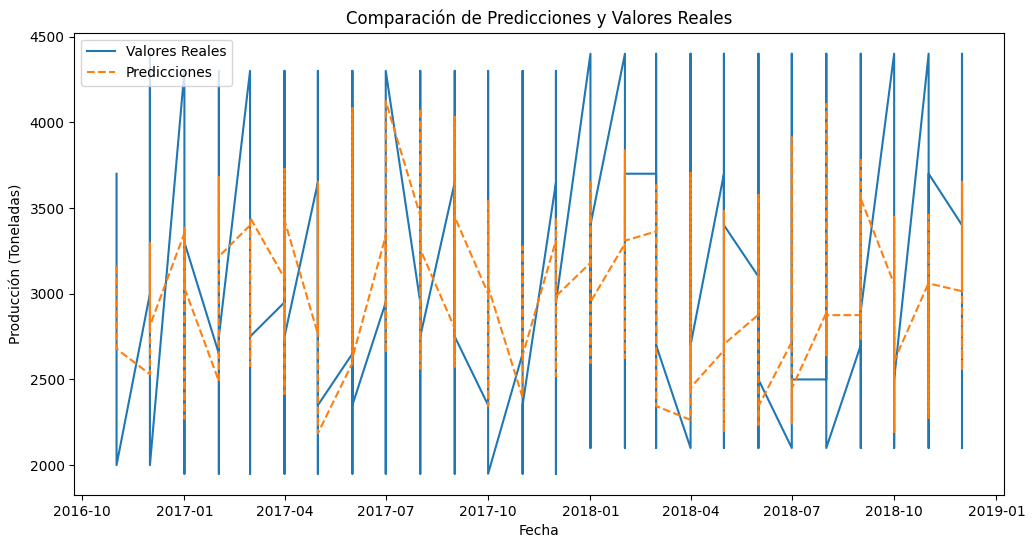

In [34]:
# Gráfico de las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['produccion_toneladas'], label='Valores Reales')
plt.plot(test.index, predictions, label='Predicciones', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Producción (Toneladas)')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()
plt.show()